In [298]:
import re
import pandas as pd
import os
import sklearn
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data_44(n_nodes, s0, seed, option=10):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v44/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'v44/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS/knockoff/knockoff_{seed}.pkl'), 'rb') as f:
        X_tilde = pickle.load(f)
    
    W_true, B_true, X = load_true_11(n_nodes, s0)
    return W['W_est'], W_true, B_true, X, X_tilde

def load_true_11(n_nodes, s0):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v11/v{n_nodes}_{n_nodes * s0}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return W_true, B_true, X

def load_data_39(n_nodes, s0, seed):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v39/W_{n_nodes}_{n_nodes * s0}_{seed}.pkl'), 'rb') as f:
        W = pickle.load(f)
    return W

def get_block(data, n_nodes=20, index=11):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def fdr_log(W):
    W11, W21 = \
        get_block(W, n_nodes=W.shape[1] // 2, index=11), \
        get_block(W, n_nodes=W.shape[1] // 2, index=21)
    
    Z = np.abs(W11) - np.abs(W21)
    fdr = 0.2
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    t_last = np.inf
    fdr_est_last = None
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
        
        T_T = Z.copy()
        mask = (T_T >= t)
        T_T[mask], T_T[~mask] = 1, 0
        perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
        fdr_true, power = perf['fdr'], perf['tpr']
    
        print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
        if fdr_est <= fdr:
            t_last = t
            fdr_est_last = fdr_est

def sys_z0_vs_deg_box(n_nodes, version_path, notes, seed=1, alpha=0.5, use_strip=True, remove_self_loop=False):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    real_p = W_est.shape[0]
    if remove_self_loop:
        W_est[np.eye(real_p, real_p).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=real_p // 2).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=-real_p // 2).astype(bool)] = 0.
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=use_strip, alpha=alpha, notes=notes)
    return df

# 20 * 80

In [121]:
"""problem 1
seed 1: from the second > 0.2, cannot select
seed 2: has < 0.2, low power
seed 3: has < 0.2, low power
seed 4: has < 0.2, low power
seed 5: has < 0.2, low power
seed 6: has < 0.2, low power
seed 7: has < 0.2, low power
seed 8: has < 0.2, low power
seed 9: has < 0.2, low power
seed 10: has < 0.2, low power

conclusion: 
statement "most edges > 0.2 so cannot be selected, but the est is quite close to true ones" not hold. because most cases have many edges < 0.2, edges can still not be selected.
but it's not clear whether est is close to true ones or not.
"""

"""problem 2, measuring when true fdr is small
seed 1: est > 0.7
seed 2: est > 1
seed 3: est > 1
seed 4: est > 1
seed 5: est > 0.6
seed 6: est > 0.6
seed 7: est > 2
seed 8: est > 1
seed 9: est > 2
seed 10: close

conclusion:
statement "est is much higher than true ones (and 0.2) such that no edge can be selected and power = 0" holds.
"""

"""CONCLUSION: most significant problem
The est is too much higher than true fdr, such no edge can be selected.
40 * 160 has the same problem
"""


'CONCLUSION: most significant problem\nThe est is too much higher than true fdr, such no edge can be selected.\n40 * 160 has the same problem\n'

In [68]:
W, W_true, B_true, X = load_data_44(20, 4, 7)
fdr_log(W)

thresh 0.4914 | est fdr 2.0000 | true fdr 0.0000 | true power 0.0000
thresh 0.4062 | est fdr 3.0000 | true fdr 0.0000 | true power 0.0000
thresh 0.2981 | est fdr 4.0000 | true fdr 0.0000 | true power 0.0000
thresh 0.2908 | est fdr 4.0000 | true fdr 0.0000 | true power 0.0125
thresh 0.2776 | est fdr 5.0000 | true fdr 0.0000 | true power 0.0125
thresh 0.2626 | est fdr 6.0000 | true fdr 0.0000 | true power 0.0125
thresh 0.2443 | est fdr 3.0000 | true fdr 0.0000 | true power 0.0250
thresh 0.2249 | est fdr 3.5000 | true fdr 0.0000 | true power 0.0250
thresh 0.2143 | est fdr 2.3333 | true fdr 0.0000 | true power 0.0375
thresh 0.1957 | est fdr 1.7500 | true fdr 0.2500 | true power 0.0375
thresh 0.1935 | est fdr 1.4000 | true fdr 0.2000 | true power 0.0500
thresh 0.1883 | est fdr 1.6000 | true fdr 0.2000 | true power 0.0500
thresh 0.1562 | est fdr 1.8000 | true fdr 0.2000 | true power 0.0500
thresh 0.1523 | est fdr 2.0000 | true fdr 0.2000 | true power 0.0500
thresh 0.1494 | est fdr 2.2000 | t

(-0.53050642387216, 1.5)

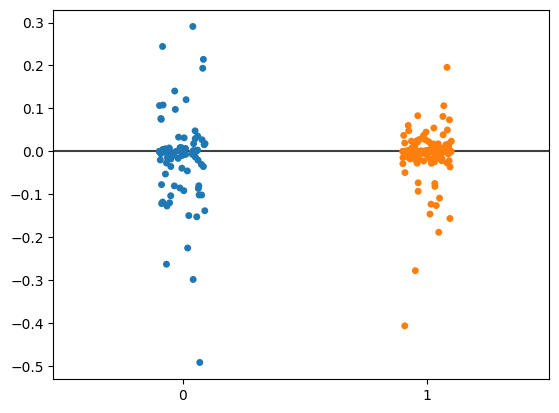

In [70]:
W11, W21 = \
    get_block(W, n_nodes=W.shape[1] // 2, index=11), \
    get_block(W, n_nodes=W.shape[1] // 2, index=21)
Z = np.abs(W11) - np.abs(W21)
ax = sns.stripplot(
    [Z[B_true].flatten(), Z[~B_true].flatten()]
)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, [0, 0], 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
ax.set_xlim(lims)
# ax.set_ylim(lims)

# 40 * 160

In [111]:
"""problem 1
seed 1: from the second > 0.2, cannot select
seed 2: has < 0.2, low power
seed 3: has < 0.2, low power
seed 4: has < 0.2, low power
seed 5: has < 0.2, low power
seed 6: has < 0.2, low power
seed 7: has < 0.2, low power
seed 8: has < 0.2, low power
seed 9: has < 0.2, low power
seed 10: has < 0.2, low power

conclusion: 
statement "most edges > 0.2 so cannot be selected, but the est is quite close to true ones" not hold. because most cases have many edges < 0.2, edges can still not be selected.
but it's not clear whether est is close to true ones or not.
"""

"""problem 2, measuring when true fdr is small
seed 1: est > 0.7
seed 2: est > 1
seed 3: est > 1
seed 4: est > 1
seed 5: est > 0.6
seed 6: est > 0.6
seed 7: est > 2
seed 8: est > 1
seed 9: est > 2
seed 10: close

conclusion:
statement "est is much higher than true ones (and 0.2) such that no edge can be selected and power = 0" holds.
"""

"""CONCLUSION: most significant problem
The est is too much higher than true fdr, such no edge can be selected.
"""


'CONCLUSION: most significant problem\nThe est is too much higher than true fdr, such no edge can be selected.\n'

In [123]:
W, W_true, B_true, X = load_data_44(40, 4, 5)
fdr_log(W)

thresh 0.2308 | est fdr 1.0000 | true fdr 0.0000 | true power 0.0063
thresh 0.2272 | est fdr 0.5000 | true fdr 0.0000 | true power 0.0125
thresh 0.2200 | est fdr 1.0000 | true fdr 0.0000 | true power 0.0125
thresh 0.2141 | est fdr 1.5000 | true fdr 0.0000 | true power 0.0125
thresh 0.2094 | est fdr 2.0000 | true fdr 0.0000 | true power 0.0125
thresh 0.1921 | est fdr 2.5000 | true fdr 0.0000 | true power 0.0125
thresh 0.1689 | est fdr 1.6667 | true fdr 0.0000 | true power 0.0187
thresh 0.1674 | est fdr 1.2500 | true fdr 0.0000 | true power 0.0250
thresh 0.1664 | est fdr 1.5000 | true fdr 0.0000 | true power 0.0250
thresh 0.1635 | est fdr 1.2000 | true fdr 0.0000 | true power 0.0312
thresh 0.1620 | est fdr 1.4000 | true fdr 0.0000 | true power 0.0312
thresh 0.1587 | est fdr 1.1667 | true fdr 0.0000 | true power 0.0375
thresh 0.1551 | est fdr 1.3333 | true fdr 0.0000 | true power 0.0375
thresh 0.1470 | est fdr 1.1429 | true fdr 0.0000 | true power 0.0437
thresh 0.1455 | est fdr 1.0000 | t

(-0.5, 1.5)

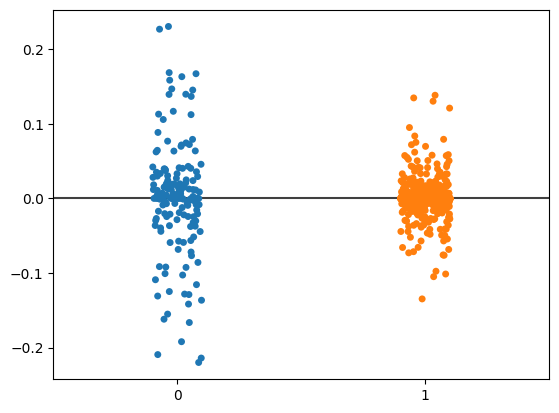

In [124]:
W11, W21 = \
    get_block(W, n_nodes=W.shape[1] // 2, index=11), \
    get_block(W, n_nodes=W.shape[1] // 2, index=21)
Z = np.abs(W11) - np.abs(W21)
ax = sns.stripplot(
    [Z[B_true].flatten(), Z[~B_true].flatten()]
)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, [0, 0], 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
ax.set_xlim(lims)
# ax.set_ylim(lims)

# 60 * 360

In [95]:
"""problem 1 (solved)
all edges fdr > 0.2 (even 0.6). It can be a problem of 1) the model fitting is not good.
2) the model fitting is good but the knockoff is not a good feature importance measure, so the ranking has problem. 
"""

"""problem 2
seed 1: larger
seed 2: quite smaller
seed 3: larger
seed 4: larger
seed 5: quite smaller
seed 6: smaller
seed 7: quite smaller
seed 8: quite smaller
seed 9: quite smaller
seed 10: quite smaller

conclusion:
most cases est fdr < true fdr, that measn the Z distribution still shift.

Compared with option 5, things not getting better.
"""

"""TODO
1) what the cause of all edges fdr > 0.6? it's 1) or 2) of problem 1?
1).1 it's caused by 1)

2) is bad model fitting leading to Z distribution shift? If yes, what aspect of "bad model fitting", like collinearity, lead to distribution shift?

Note that existing problems same as last time option_5_OLS
"""

"""Note
When model fitting is bad, no edge can be selected with fdr < 0.2 no matter Z distribution shift exists or not. In other words, even when no Z shift (the best case),
the resulted fdr and power would always be 0. So it doesn't make sense to directly compare fdr and power.

however, we shall compare Z distribution shift. So the question is: 
is bad model fitting leading to Z distribution shift? If yes, what aspect of "bad model fitting", like collinearity, lead to distribution shift?

the benefits of investigating this problem: the Z distribution shift should not rely on model fitting performance. Because 1) model fitting performance is bad while users
don't know, our fdr control will provide many wrong features. In other words, that makes our method only applicable to good model, which may be unknown to users. 2) Even when
users deal with bad models, the best option is NOT providing a threshold (or many wrong features). It should instead provide NO threshold (NO features) at all. 
Since intuitively, features above any threshold given by a bad model could include many wrong features.
"""

'Note\nWhen model fitting is bad, no edge can be selected with fdr < 0.2 no matter Z distribution shift exists or not. In other words, even when no Z shift (the best case),\nthe resulted fdr and power would always be 0. So it doesn\'t make sense to directly compare fdr and power.\n\nhowever, we shall compare Z distribution shift. So the question is: \nis bad model fitting leading to Z distribution shift? If yes, what aspect of "bad model fitting", like collinearity, lead to distribution shift?\n\nthe benefits of investigating this problem: the Z distribution shift should not rely on model fitting performance. Because 1) model fitting performance is bad while users\ndon\'t know, our fdr control will provide many wrong features. In other words, that makes our method only applicable to good model, which may be unknown to users. 2) Even when\nusers deal with bad models, the best option is NOT providing a threshold (or many wrong features). It should instead provide NO threshold (NO feature

In [2]:
W, W_true, B_true, X = load_data_44(60, 6, 2)
fdr_log(W)

thresh 6.3100 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 4.0699 | est fdr 0.5000 | true fdr 0.5000 | true power 0.0028
thresh 3.2572 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0028
thresh 3.1643 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0028
thresh 2.8791 | est fdr 0.5000 | true fdr 0.5000 | true power 0.0056
thresh 2.4591 | est fdr 0.4000 | true fdr 0.6000 | true power 0.0056
thresh 2.4447 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0056
thresh 2.2063 | est fdr 0.2857 | true fdr 0.7143 | true power 0.0056
thresh 2.0853 | est fdr 0.2500 | true fdr 0.7500 | true power 0.0056
thresh 2.0483 | est fdr 0.2222 | true fdr 0.7778 | true power 0.0056
thresh 1.9919 | est fdr 0.2000 | true fdr 0.8000 | true power 0.0056
thresh 1.9430 | est fdr 0.1818 | true fdr 0.7273 | true power 0.0083
thresh 1.8960 | est fdr 0.1667 | true fdr 0.6667 | true power 0.0111
thresh 1.8510 | est fdr 0.2500 | true fdr 0.6667 | true power 0.0111
thresh 1.8182 | est fdr 0.2308 | t

(-3.638063469066063, 6.783764656254034)

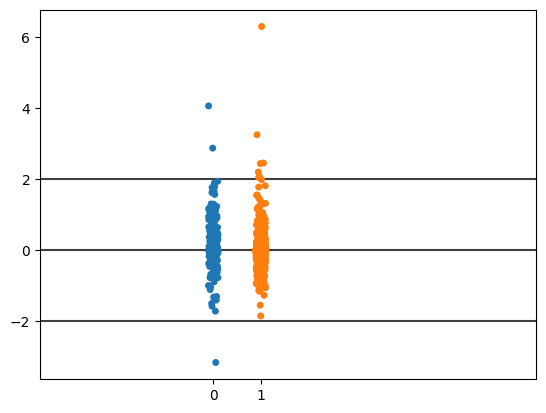

In [132]:
W11, W21 = \
    get_block(W, n_nodes=W.shape[1] // 2, index=11), \
    get_block(W, n_nodes=W.shape[1] // 2, index=21)
Z = np.abs(W11) - np.abs(W21)
ax = sns.stripplot(
    [Z[B_true].flatten(), Z[~B_true].flatten()]
)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, [0, 0], 'k-', alpha=0.75, zorder=0)
ax.plot(lims, [2, 2], 'k-', alpha=0.75, zorder=0)
ax.plot(lims, [-2, -2], 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
ax.set_xlim(lims)
# ax.set_ylim(lims)

# in 60 * 360, how is model fitting compared with 60 * 240

In [90]:
"""Note
1) The (0., 1.) is added by sklearn, not a real point.
"""

"""observation
1) 60 * 360 has quite poor model 

"""

'Note\nThe (0., 1.) is added by sklearn, not a real point.\n'

In [96]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, r2_score

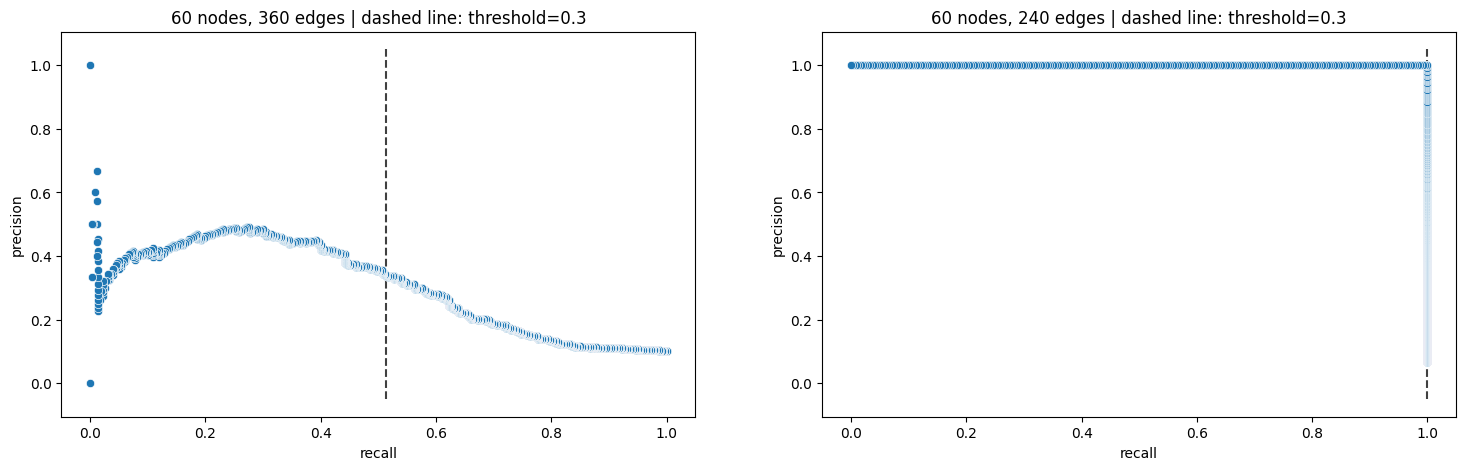

In [92]:
def draw_pr_curve(n_nodes, s0, seed, ax):
    W = load_data_39(n_nodes, s0, seed)
    _, B_true, _ = load_true_11(n_nodes, s0)
    prec, rec, threshold = precision_recall_curve(B_true.flatten(), np.abs(W).flatten())
    sns.scatterplot(x=rec, y=prec, alpha=1, ax=ax)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title(f'{n_nodes} nodes, {n_nodes * s0} edges | dashed line: threshold=0.3')
    idx = np.where(threshold > 0.3)[0][0]
    target_rec = rec[idx]
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot([target_rec, target_rec], lims, 'k--', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    # ax.set_xlim(lims)
    # ax.set_ylim(lims)
    return prec, rec, threshold
    

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

ax=axs[0]
n_nodes = 60
s0 = 6
seed = 1
prec360, rec360, thresh360 = draw_pr_curve(n_nodes, s0, seed, ax=ax)


ax=axs[1]
n_nodes = 60
s0 = 4
seed = 1
prec240, rec240, thresh240 = draw_pr_curve(n_nodes, s0, seed, ax=ax)


n_nodes 20 | n_edges 80 | density 0.2105 | CAN control FDR
n_nodes 20 | n_edges 120 | density 0.3158 | CAN control FDR
n_nodes 40 | n_edges 160 | density 0.1026 | CAN control FDR
n_nodes 40 | n_edges 240 | density 0.1538 | CAN control FDR
n_nodes 60 | n_edges 240 | density 0.0678 | CAN control FDR
n_nodes 60 | n_edges 360 | density 0.1017 | CANNOT control FDR
n_nodes 80 | n_edges 320 | density 0.0506 | CAN control FDR
n_nodes 80 | n_edges 480 | density 0.0759 | CANNOT control FDR
n_nodes 100 | n_edges 400 | density 0.0404 | CAN control FDR
n_nodes 100 | n_edges 600 | density 0.0606 | CAN control FDR


Text(7, 0.0759493670886076, 'CANNOT')

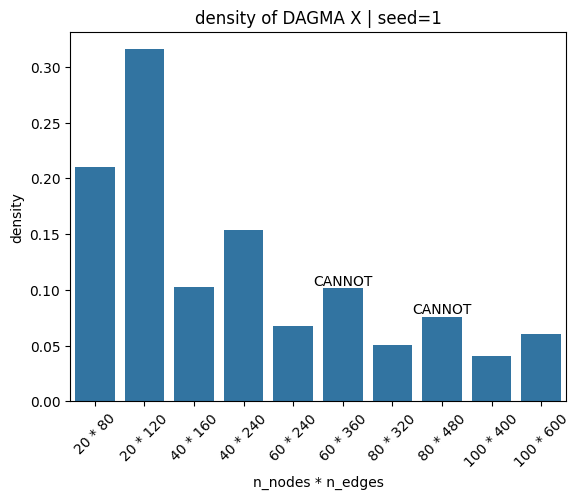

In [340]:
"""Conclusion
The density is NOT the cause of losing fdr control
"""
names = []
numbers = []
for n_nodes in [20, 40, 60, 80, 100]:
    for s0 in [4, 6]:
        W_true, B_true, X = load_true_11(n_nodes, s0)
        G = nx.DiGraph(B_true)
        if n_nodes in [60, 80] and s0 == 6:
            control = 'CANNOT'
        else:
            control = "CAN"
        names.append(f"{n_nodes} * {n_nodes * s0}")
        numbers.append(nx.density(G))
        print(f"n_nodes {n_nodes} | n_edges {n_nodes * s0} | density {nx.density(G):.4f} | {control} control FDR")

ax = sns.barplot(x=names, y=numbers)
plt.xticks(rotation=45)
ax.set_xlabel("n_nodes * n_edges")
ax.set_ylabel("density")
ax.set_title("density of DAGMA X | seed=1")
plt.text(5, numbers[5], "CANNOT", ha='center', va='bottom')
plt.text(7, numbers[7], "CANNOT", ha='center', va='bottom')

n_nodes 20 | n_edges 80 | cond 627.2474 | CAN control FDR
n_nodes 20 | n_edges 120 | cond 1662.9118 | CAN control FDR
n_nodes 40 | n_edges 160 | cond 904.4200 | CAN control FDR
n_nodes 40 | n_edges 240 | cond 6759.8955 | CAN control FDR
n_nodes 60 | n_edges 240 | cond 1846.8276 | CAN control FDR
n_nodes 60 | n_edges 360 | cond 505973.5637 | CANNOT control FDR
n_nodes 80 | n_edges 320 | cond 3322.3553 | CAN control FDR
n_nodes 80 | n_edges 480 | cond 81563.0707 | CANNOT control FDR
n_nodes 100 | n_edges 400 | cond 5313.0482 | CAN control FDR
n_nodes 100 | n_edges 600 | cond 19315.0914 | CAN control FDR


Text(7, 81563.07072716033, 'CANNOT')

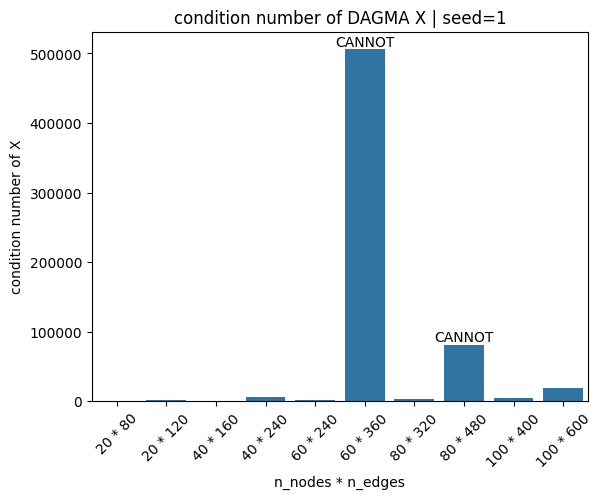

In [342]:
names = []
numbers = []
for n_nodes in [20, 40, 60, 80, 100]:
    for s0 in [4, 6]:
        W_true, B_true, X = load_true_11(n_nodes, s0)
        G = nx.DiGraph(B_true)
        if n_nodes in [60, 80] and s0 == 6:
            control = 'CANNOT'
        else:
            control = "CAN"
        names.append(f"{n_nodes} * {n_nodes * s0}")
        cond = np.linalg.cond(X)
        numbers.append(cond)
        print(f"n_nodes {n_nodes} | n_edges {n_nodes * s0} | cond {cond:.4f} | {control} control FDR")

ax = sns.barplot(x=names, y=numbers)
plt.xticks(rotation=45)
ax.set_xlabel("n_nodes * n_edges")
ax.set_ylabel("condition number of X")
ax.set_title("condition number of DAGMA X | seed=1")
plt.text(5, numbers[5], "CANNOT", ha='center', va='bottom')
plt.text(7, numbers[7], "CANNOT", ha='center', va='bottom')

n_nodes 20 | n_edges 80 | cond 627.2474 | CAN control FDR
n_nodes 20 | n_edges 120 | cond 1662.9118 | CAN control FDR
n_nodes 40 | n_edges 160 | cond 904.4200 | CAN control FDR
n_nodes 40 | n_edges 240 | cond 6759.8955 | CAN control FDR
n_nodes 60 | n_edges 240 | cond 1846.8276 | CAN control FDR
n_nodes 60 | n_edges 360 | cond 505973.5637 | CANNOT control FDR
n_nodes 80 | n_edges 320 | cond 3322.3553 | CAN control FDR
n_nodes 80 | n_edges 480 | cond 81563.0707 | CANNOT control FDR
n_nodes 100 | n_edges 400 | cond 5313.0482 | CAN control FDR
n_nodes 100 | n_edges 600 | cond 19315.0914 | CAN control FDR


Text(7, 81563.07072716033, 'CANNOT')

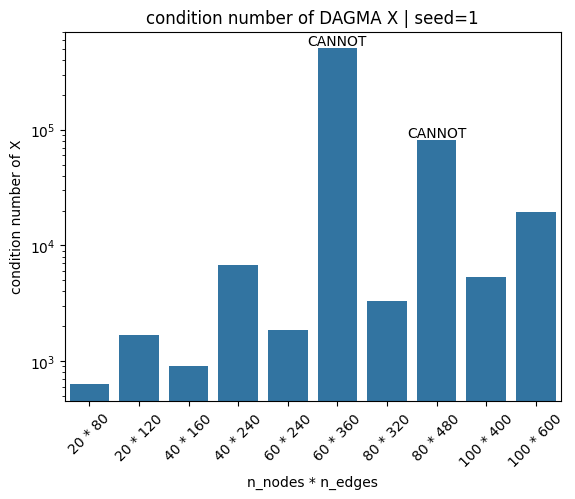

In [376]:
names = []
numbers = []
for n_nodes in [20, 40, 60, 80, 100]:
    for s0 in [4, 6]:
        W_true, B_true, X = load_true_11(n_nodes, s0)
        G = nx.DiGraph(B_true)
        if n_nodes in [60, 80] and s0 == 6:
            control = 'CANNOT'
        else:
            control = "CAN"
        names.append(f"{n_nodes} * {n_nodes * s0}")
        cond = np.linalg.cond(X)
        numbers.append(cond)
        print(f"n_nodes {n_nodes} | n_edges {n_nodes * s0} | cond {cond:.4f} | {control} control FDR")

ax = sns.barplot(x=names, y=numbers)
plt.xticks(rotation=45)
ax.set_xlabel("n_nodes * n_edges")
ax.set_ylabel("condition number of X")
ax.set_title("condition number of DAGMA X | seed=1")
ax.set(yscale='log')
plt.text(5, numbers[5], "CANNOT", ha='center', va='bottom')
plt.text(7, numbers[7], "CANNOT", ha='center', va='bottom')

n_nodes 20 | n_edges 80 | r2 0.8280 | CAN control FDR
n_nodes 20 | n_edges 120 | r2 0.7520 | CAN control FDR
n_nodes 40 | n_edges 160 | r2 0.8357 | CAN control FDR
n_nodes 40 | n_edges 240 | r2 0.5882 | CAN control FDR
n_nodes 60 | n_edges 240 | r2 0.8465 | CAN control FDR
n_nodes 60 | n_edges 360 | r2 -0.2439 | CANNOT control FDR
n_nodes 80 | n_edges 320 | r2 0.7657 | CAN control FDR
n_nodes 80 | n_edges 480 | r2 0.6096 | CANNOT control FDR
n_nodes 100 | n_edges 400 | r2 0.7752 | CAN control FDR
n_nodes 100 | n_edges 600 | r2 0.7325 | CAN control FDR


Text(7, 0.6095528278738633, 'CANNOT')

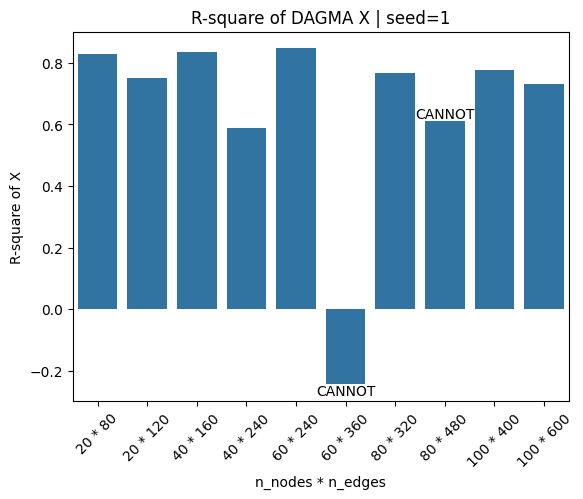

In [349]:
names = []
numbers = []
for n_nodes in [20, 40, 60, 80, 100]:
    for s0 in [4, 6]:
        W_true, B_true, X = load_true_11(n_nodes, s0)
        W = load_data_39(n_nodes, s0, 1)
        G = nx.DiGraph(B_true)
        if n_nodes in [60, 80] and s0 == 6:
            control = 'CANNOT'
        else:
            control = "CAN"
        names.append(f"{n_nodes} * {n_nodes * s0}")
        r2 = r2_score(W_true, W)
        numbers.append(r2)
        print(f"n_nodes {n_nodes} | n_edges {n_nodes * s0} | r2 {r2:.4f} | {control} control FDR")

ax = sns.barplot(x=names, y=numbers)
plt.xticks(rotation=45)
ax.set_xlabel("n_nodes * n_edges")
ax.set_ylabel("R-square of X")
ax.set_title("R-square of DAGMA X | seed=1")
plt.text(5, numbers[5], "CANNOT", ha='center', va='top')
plt.text(7, numbers[7], "CANNOT", ha='center', va='bottom')

<Axes: >

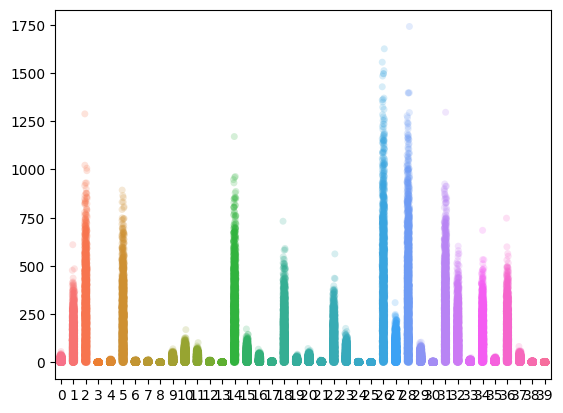

In [214]:
n_nodes=40
s0=6
W_true, B_true, X = load_true_11(n_nodes, s0)
sns.stripplot(np.abs(X), alpha=0.2)

<Axes: >

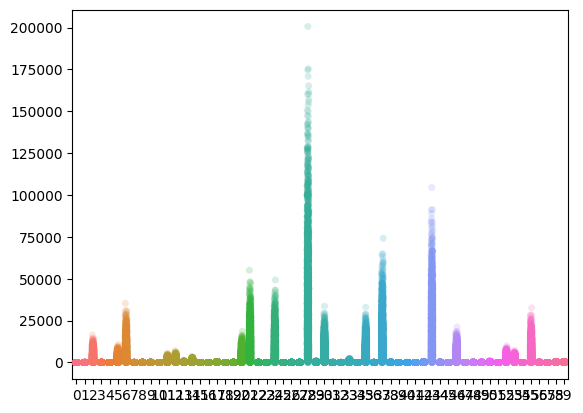

In [229]:
n_nodes=60
s0=6
W_true, B_true, X = load_true_11(n_nodes, s0)
sns.stripplot(np.abs(X), alpha=0.2)

<Axes: >

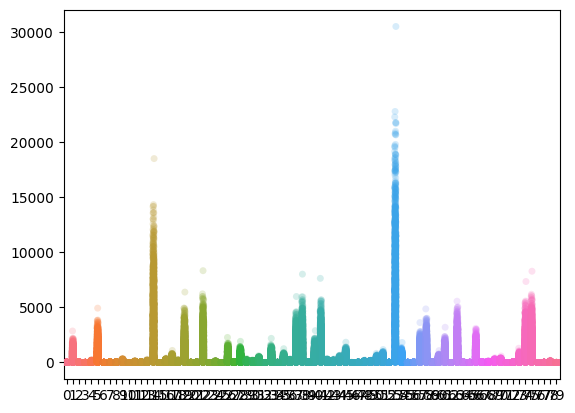

In [217]:
n_nodes=80
s0=6
W_true, B_true, X = load_true_11(n_nodes, s0)
sns.stripplot(np.abs(X), alpha=0.2)

<Axes: >

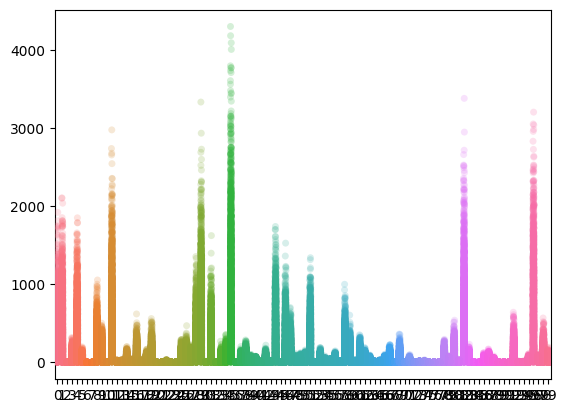

In [216]:
n_nodes=100
s0=6
W_true, B_true, X = load_true_11(n_nodes, s0)
sns.stripplot(np.abs(X), alpha=0.2)

In [366]:
6 % 5

1

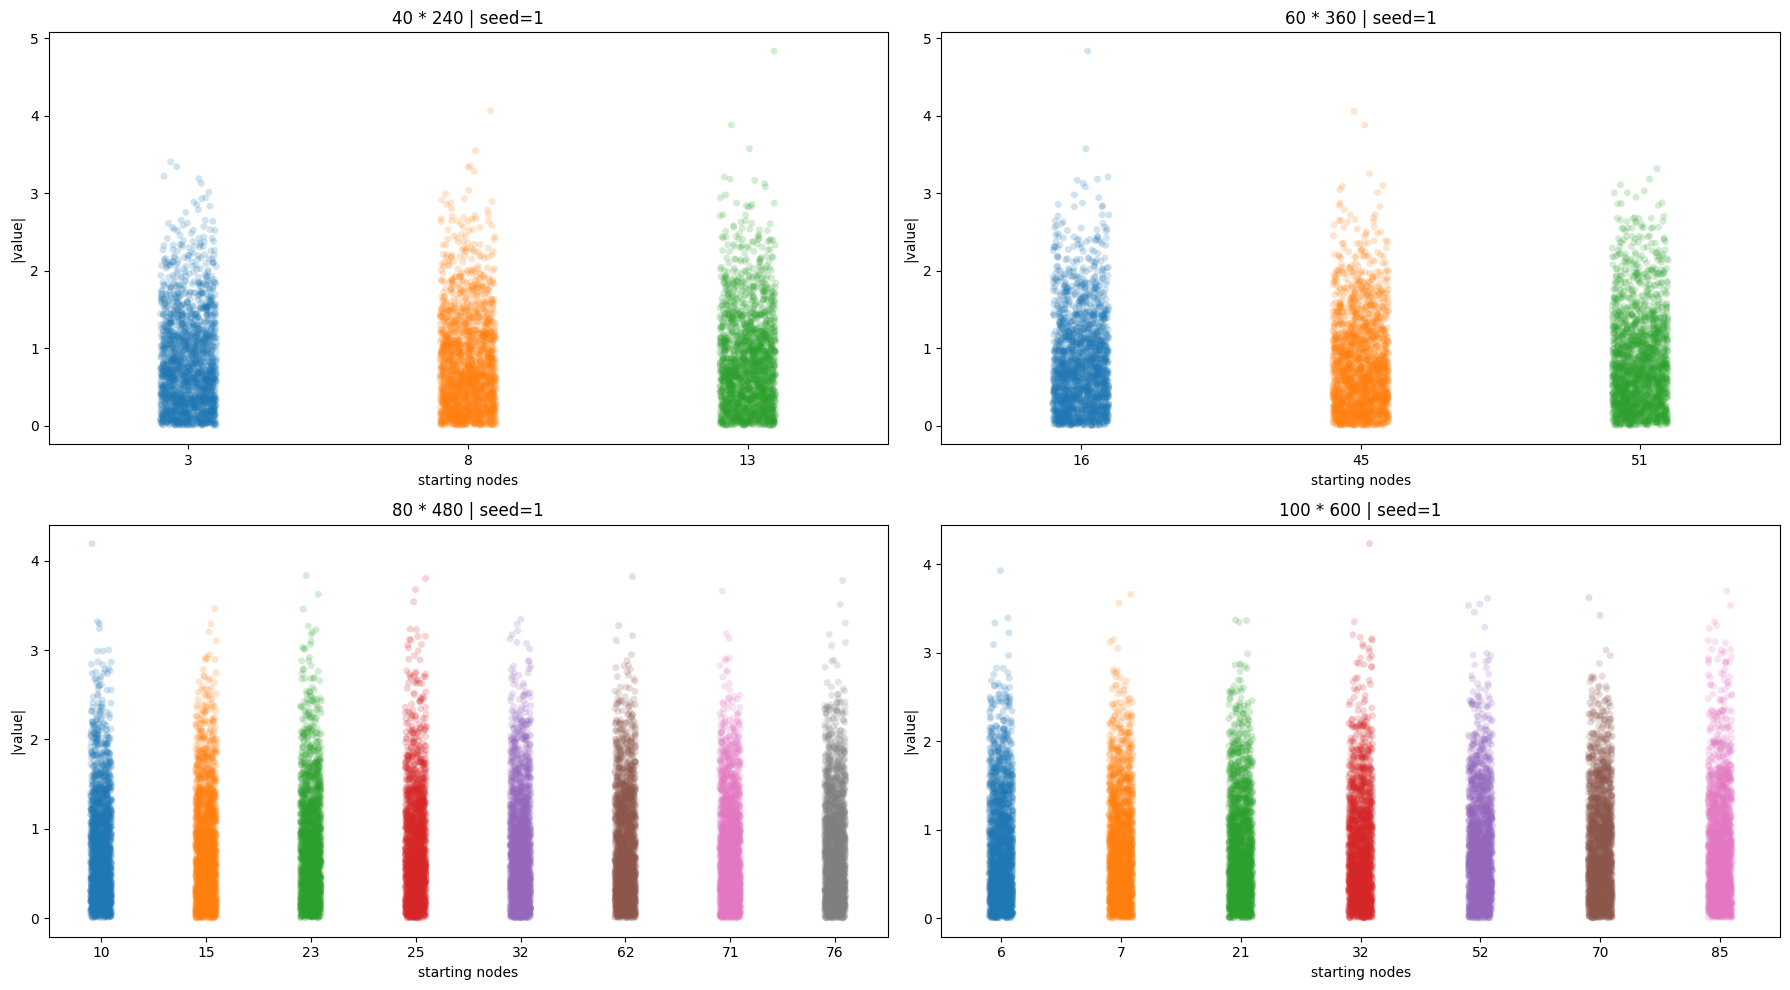

In [368]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

i = 0
for n_nodes in [40, 60, 80, 100]:
    ax = axs[i // 2][i % 2]
    s0 = 6
    seed = 1
    W_true, B_true, X = load_true_11(n_nodes, s0)
    start_mask = np.where(B_true.sum(axis=0) == 0)[0]
    sns.stripplot(np.abs(X[:, start_mask]), alpha=0.2, ax=ax)
    ax.set_xticks(range(len(start_mask)), start_mask)
    ax.set_xlabel("starting nodes")
    ax.set_ylabel("|value|")
    ax.set_title(f"{n_nodes} * {n_nodes * s0} | seed=1")
    i += 1
plt.tight_layout()

<Axes: >

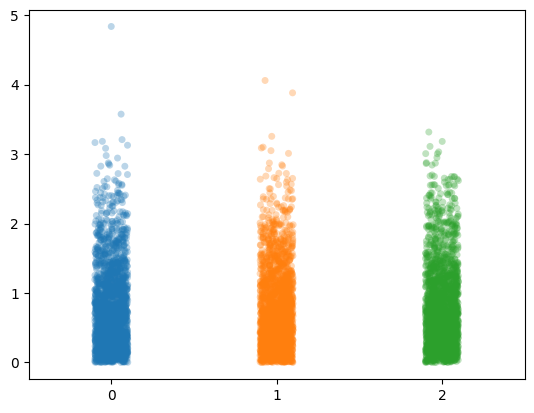

<Axes: >

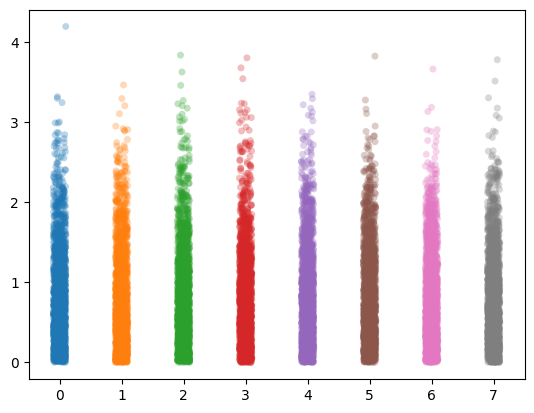

<Axes: >

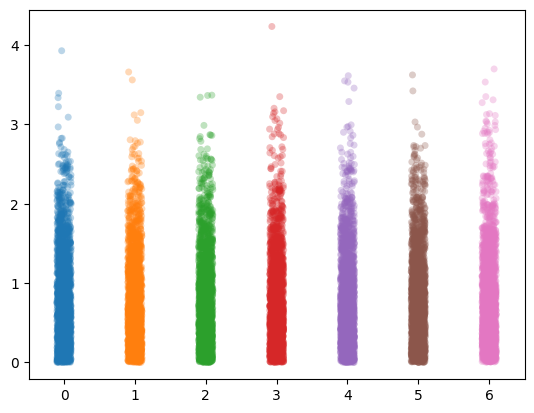

# |X| related to path length?

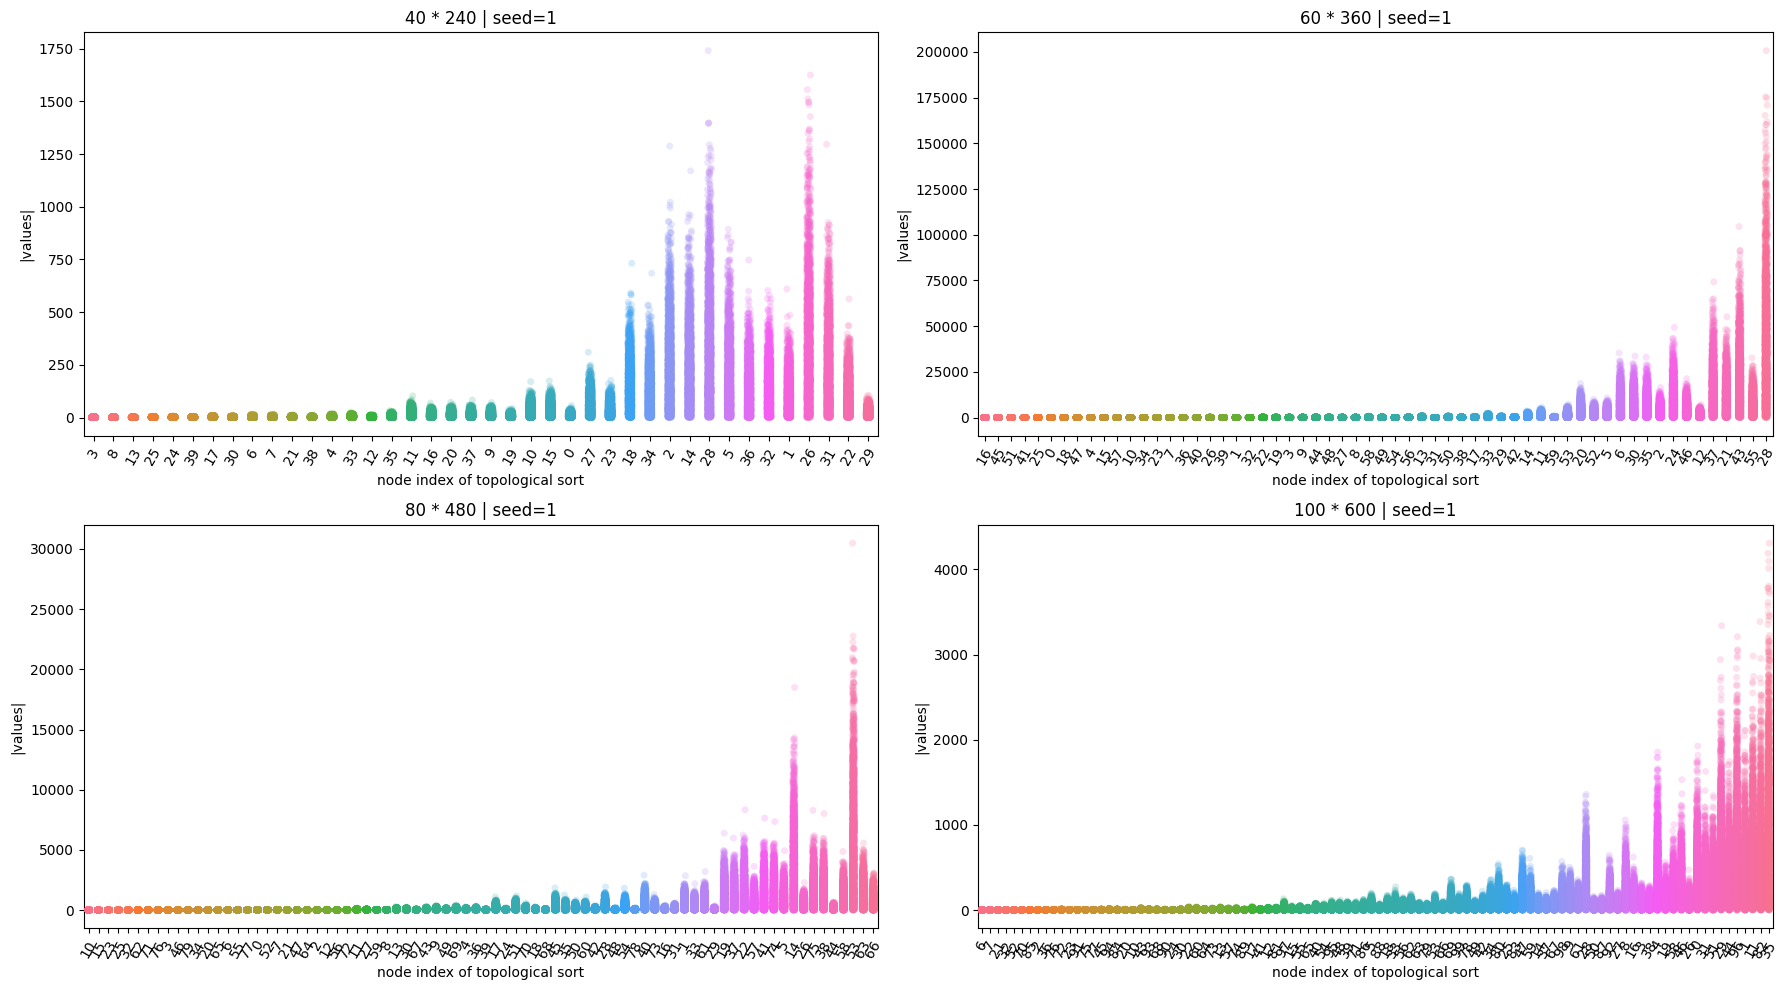

In [359]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

ax = axs[0][0]
n_nodes = 40
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
sns.stripplot(np.abs(X[:, topo_nodes]), alpha=0.2, ax=ax)
ax.set_xlabel("node index of topological sort")
ax.set_ylabel("|values|")
ax.set_xticks(list(range(len(topo_nodes))), topo_nodes, rotation=60)
ax.set_title(f"{n_nodes} * {n_nodes * s0} | seed=1")

ax = axs[0][1]
n_nodes = 60
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
sns.stripplot(np.abs(X[:, topo_nodes]), alpha=0.2, ax=ax)
ax.set_xlabel("node index of topological sort")
ax.set_ylabel("|values|")
ax.set_xticks(list(range(len(topo_nodes))), topo_nodes, rotation=60)
ax.set_title(f"{n_nodes} * {n_nodes * s0} | seed=1")

ax = axs[1][0]
n_nodes = 80
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
sns.stripplot(np.abs(X[:, topo_nodes]), alpha=0.2, ax=ax)
ax.set_xlabel("node index of topological sort")
ax.set_ylabel("|values|")
ax.set_xticks(list(range(len(topo_nodes))), topo_nodes, rotation=60)
ax.set_title(f"{n_nodes} * {n_nodes * s0} | seed=1")

ax = axs[1][1]
n_nodes = 100
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
sns.stripplot(np.abs(X[:, topo_nodes]), alpha=0.2, ax=ax)
ax.set_xlabel("node index of topological sort")
ax.set_ylabel("|values|")
ax.set_xticks(list(range(len(topo_nodes))), topo_nodes, rotation=60)
ax.set_title(f"{n_nodes} * {n_nodes * s0} | seed=1")


# topo_depth = 0
# in_deg = B_true.sum(axis=0)
# vis_n = np.zeros_like(in_deg)
# while not (in_deg == 0.).all():
#     no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
#     for n in no_in_deg_nodes:
#         successors = list(G.successors(n))
#         in_deg[successors] -= 1
#         assert (in_deg >= 0).all()
#     vis_n[no_in_deg_nodes] = 1
#     topo_depth += 1
# print(topo_depth)

# nx.write_gexf(G, f'../simulated_data/v11/v{n_nodes}_{n_nodes * s0}/X/G_B_true_1.gexf')

plt.tight_layout()

In [373]:
i = 0
for n_nodes in [40, 60, 80, 100]:
    s0 = 6
    seed = 1
    W_true, B_true, X = load_true_11(n_nodes, s0)
    G = nx.DiGraph(B_true)
    topo_depth = 0
    in_deg = B_true.sum(axis=0)
    vis_n = np.zeros_like(in_deg)
    while not (in_deg == 0.).all():
        no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
        for n in no_in_deg_nodes:
            successors = list(G.successors(n))
            in_deg[successors] -= 1
            assert (in_deg >= 0).all()
        vis_n[no_in_deg_nodes] = 1
        topo_depth += 1
    print(f"{n_nodes} * {n_nodes * s0}: depth of topological sort {topo_depth}")

40 * 240: depth of topological sort 14
60 * 360: depth of topological sort 21
80 * 480: depth of topological sort 20
100 * 600: depth of topological sort 18


20

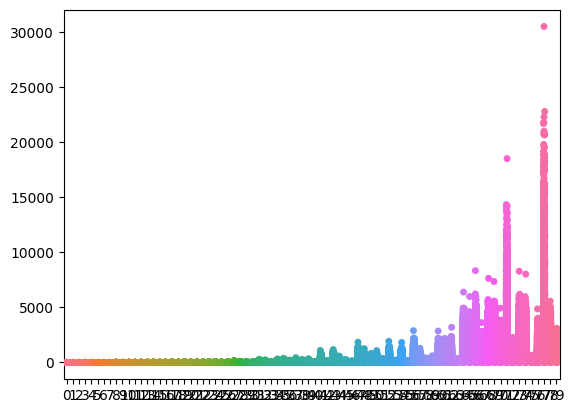

In [284]:
n_nodes = 80
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
ax = sns.stripplot(np.abs(X[:, topo_nodes]))

topo_depth = 0
in_deg = B_true.sum(axis=0)
vis_n = np.zeros_like(in_deg)
while not (in_deg == 0.).all():
    no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
    for n in no_in_deg_nodes:
        successors = list(G.successors(n))
        in_deg[successors] -= 1
        assert (in_deg >= 0).all()
    vis_n[no_in_deg_nodes] = 1
    topo_depth += 1
topo_depth

18

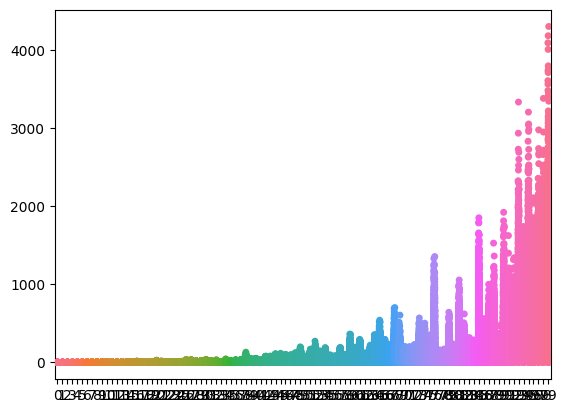

In [279]:
n_nodes = 100
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
ax = sns.stripplot(np.abs(X[:, topo_nodes]))

topo_depth = 0
in_deg = B_true.sum(axis=0)
vis_n = np.zeros_like(in_deg)
while not (in_deg == 0.).all():
    no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
    for n in no_in_deg_nodes:
        successors = list(G.successors(n))
        in_deg[successors] -= 1
        assert (in_deg >= 0).all()
    vis_n[no_in_deg_nodes] = 1
    topo_depth += 1
topo_depth

14

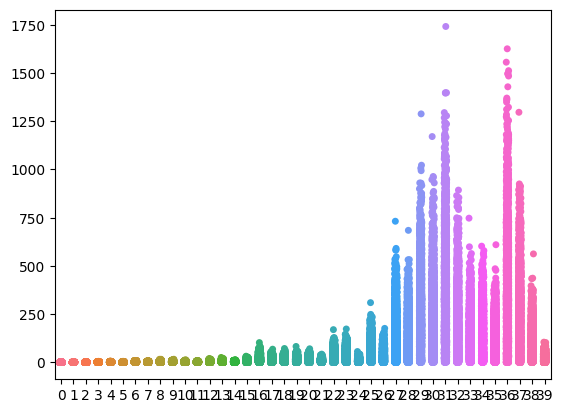

In [280]:
n_nodes = 40
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
ax = sns.stripplot(np.abs(X[:, topo_nodes]))

topo_depth = 0
in_deg = B_true.sum(axis=0)
vis_n = np.zeros_like(in_deg)
while not (in_deg == 0.).all():
    no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
    for n in no_in_deg_nodes:
        successors = list(G.successors(n))
        in_deg[successors] -= 1
        assert (in_deg >= 0).all()
    vis_n[no_in_deg_nodes] = 1
    topo_depth += 1
topo_depth

11

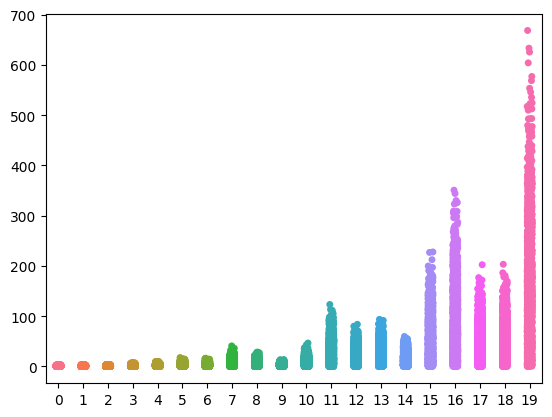

In [281]:
n_nodes = 20
s0 = 6
seed = 1
W_true, B_true, X = load_true_11(n_nodes, s0)
G = nx.DiGraph(B_true)
topo_nodes = list(nx.topological_sort(G))
ax = sns.stripplot(np.abs(X[:, topo_nodes]))

topo_depth = 0
in_deg = B_true.sum(axis=0)
vis_n = np.zeros_like(in_deg)
while not (in_deg == 0.).all():
    no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
    for n in no_in_deg_nodes:
        successors = list(G.successors(n))
        in_deg[successors] -= 1
        assert (in_deg >= 0).all()
    vis_n[no_in_deg_nodes] = 1
    topo_depth += 1
topo_depth

# large |z| most between large |X| and small |X|?

In [303]:
n_nodes = 60
s0 = 6
seed = 5
W, W_true, B_true, X, X_tilde = load_data_44(n_nodes, s0, seed, option=5)

In [304]:
W11, W21 = get_block(W, n_nodes, 11), get_block(W, n_nodes, 21)
Z = np.abs(W11) - np.abs(W21)

<Axes: >

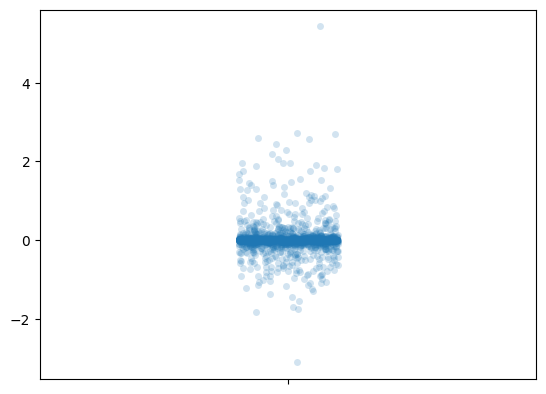

In [312]:
sns.stripplot(Z.flatten(), alpha=0.2)

In [313]:
np.where(Z == Z.max())

(array([18]), array([55]))

In [314]:
W11[18, 55]

5.470975879402683

In [315]:
W21[18, 55]

0.039741337552634814

<Axes: >

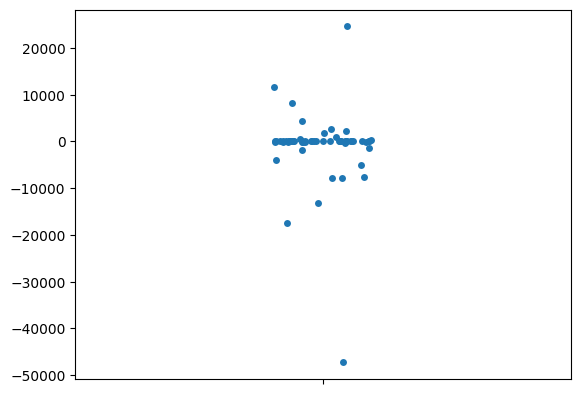

In [321]:
sns.stripplot(X[18])

<Axes: >

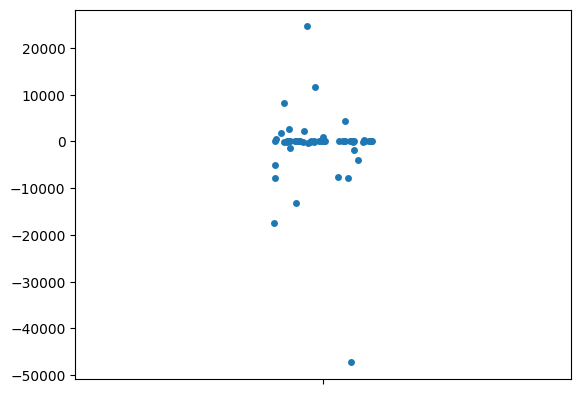

In [319]:
sns.stripplot(X_tilde[18])

<Axes: >

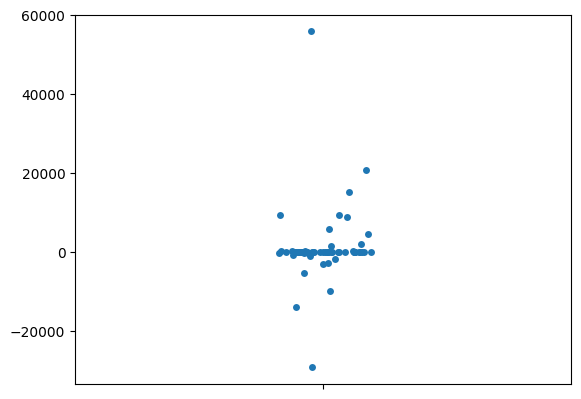

In [318]:
sns.stripplot(X[55])